# Group 14 - Project FP01
## Time series anomaly detection - DAGMM

This project aims at investigating the current state-of-the-arts TAD scenario.

In [1]:
# !pip install pandas==1.5.3
# !pip install tsfel
# !pip install keras_tuner
# !pip install -U kaleido

In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from dataset import *
from plots import *
from metrics import *

#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

# Set style for matplotlib
plt.style.use("Solarize_Light2")

In [3]:
# Path to the root directory of the dataset
ROOTDIR_DATASET_NORMAL =  '../dataset/normal'#'/content/drive/MyDrive/Kuka_v1/normal'
ROOTDIR_DATASET_ANOMALY = '../dataset/collisions'#'/content/drive/MyDrive/Kuka_v1/collisions'

# TF_ENABLE_ONEDNN_OPTS=0 means that the model will not use the oneDNN library for optimization

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

### Dataset: Kuka-v1
In 5 different recording sessions, the robot executes several different operations, while being
monitored by several sensors. The sensed signals are collected, with different sampling frequencies
(1, 10, 100, 200 Hz),

### Data Loading

In [4]:

#freq = '1.0'
freq = '0.1'
#freq = '0.01'
#freq = '0.005'

# NORMAL DATA
filepath_csv = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.csv") for r in [0, 2, 3, 4]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.metadata") for r in [0, 2, 3, 4]]
df_action, df, df_meta, action2int = get_df_action(filepath_csv, filepath_meta)

# COLLISION DATA
filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.csv") for r in [1, 5]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.metadata") for r in [1, 5]]
df_action_collision, df_collision, df_meta_collision, action2int_collision = get_df_action(filepath_csv, filepath_meta)

filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec1_collision_20220811_rbtc_{freq}s.csv")]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec1_collision_20220811_rbtc_{freq}s.metadata")]
df_action_collision_1, df_collision_1, df_meta_collision_1, action2int_collision_1 = get_df_action(filepath_csv, filepath_meta)

filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec5_collision_20220811_rbtc_{freq}s.csv")]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec5_collision_20220811_rbtc_{freq}s.metadata")]
df_action_collision_5, df_collision_5, df_meta_collision_5, action2int_collision_5 = get_df_action(filepath_csv, filepath_meta)

# COLLISION LABEL
xls = pd.ExcelFile(os.path.join(ROOTDIR_DATASET_ANOMALY, "20220811_collisions_timestamp_v2.xlsx"))
collision_rec1 = pd.read_excel(xls, 'rec1')

collisions_adjusted_rec_1 = collision_rec1.Timestamp - pd.to_timedelta([2] * len(collision_rec1.Timestamp), 'h')
collision_rec1['Timestamp'] = collisions_adjusted_rec_1
collisions_init1 = collision_rec1[collision_rec1['Inizio/fine'] == "i"].Timestamp

collision_rec5 = pd.read_excel(xls, 'rec5')
collisions_adjusted_rec_5 = collision_rec5.Timestamp - pd.to_timedelta([2] * len(collision_rec5.Timestamp), 'h')
collision_rec5['Timestamp'] = collisions_adjusted_rec_5
collisions_init5 = collision_rec5[collision_rec5['Inizio/fine'] == "i"].Timestamp

collisions = pd.concat([collision_rec1, collision_rec5])
collisions_init = collisions[collisions['Inizio/fine'] == "i"].Timestamp

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.



### Features Exctraction

In [5]:
start_time = time.time()
frequency = 1/float(freq)
print(frequency)
df_features = get_features_ts("statistical", df_action, df_meta, frequency, action2int, save_dir="../features/df_features/LSTM_ED/")
df_features_collision = get_features_ts("statistical", df_action_collision, df_meta_collision, frequency, action2int_collision, save_dir="../features/df_features_collisions/LSTM_ED/")
df_features_collision_1 = get_features_ts("statistical", df_action_collision_1, df_meta_collision_1, frequency, action2int_collision_1, save_dir="../features/df_features_collisions_1/LSTM_ED/")
df_features_collision_5 = get_features_ts("statistical", df_action_collision_5, df_meta_collision_5, frequency, action2int_collision_5, save_dir="../features/df_features_collisions_5/LSTM_ED/")
print("--- %s seconds ---" % (time.time() - start_time))

10.0
Loading features from file.
Loading features from file.
Loading features from file.
Loading features from file.
--- 2.172192335128784 seconds ---


In [6]:
def find_collisions_zones(collisions):
    ts_starts = collisions[collisions['Inizio/fine'] == 'i'].Timestamp.reset_index()
    ts_ends = collisions[collisions['Inizio/fine'] == 'f'].Timestamp.reset_index()
    d = {'start': ts_starts.Timestamp, 'end': ts_ends.Timestamp}
    collision_zones = pd.DataFrame(d)
    return collision_zones

In [7]:
collisions_zones = find_collisions_zones(collisions)
collisions_zones_1 = find_collisions_zones(collision_rec1)
collisions_zones_5 = find_collisions_zones(collision_rec5)

In [8]:
X_train, y_train, X_test, y_test, X_test_start_end = get_train_test_data(df_features, df_features_collision, full_normal=True)
X_train1, y_train1, X_test1, y_test1, X_test_start_end1 = get_train_test_data(df_features, df_features_collision_1, full_normal=True)
X_train5, y_train5, X_test5, y_test5,  X_test_start_end5 = get_train_test_data(df_features, df_features_collision_5, full_normal=True)

c:\Users\VG User\Documents\GitHub\MLinAPP-FP01-14\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but VarianceThreshold was fitted with feature names
  warnings.warn(
c:\Users\VG User\Documents\GitHub\MLinAPP-FP01-14\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but VarianceThreshold was fitted with feature names
  warnings.warn(
c:\Users\VG User\Documents\GitHub\MLinAPP-FP01-14\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but VarianceThreshold was fitted with feature names
  warnings.warn(


In [9]:
df_with_labels = label_collision_data(df_features_collision, collisions_init)
df_with_labels_1 = label_collision_data(df_features_collision_1, collisions_init1)
df_with_labels_5 = label_collision_data(df_features_collision_5, collisions_init5)

In [10]:
y_collision = df_with_labels['is_collision']
y_collision_1 = df_with_labels_1['is_collision']
y_collision_5 = df_with_labels_5['is_collision']

In [11]:
df_features_collision.drop(columns=['is_collision'], inplace=True)
df_features_collision_1.drop(columns=['is_collision'], inplace=True)
df_features_collision_5.drop(columns=['is_collision'], inplace=True)

In [12]:
np.count_nonzero(y_collision), np.count_nonzero(y_collision_1), np.count_nonzero(y_collision_5)

(105, 35, 70)

## DAGMM


In [13]:
from algorithms.dagmm import DAGMM

classifier = DAGMM(
    num_epochs=100,
    lambda_energy=0.1,
    lambda_cov_diag=0.01,
    lr=1e-4,
    batch_size=32,
    gmm_k=4,
    normal_percentile=80,
    sequence_length=30,
    autoencoder_type=DAGMM.AutoEncoder.LSTM,  # Using LSTM autoencoder
    hidden_size=16,
    autoencoder_args={
        'n_layers': (1, 1),
        'use_bias': (True, True),
        'dropout': (0.1, 0.1)
    },
    seed=42,
    gpu=None,  # Set to None for CPU, or specify GPU index if available
    details=True
)

# Train the DAGMM on normal data
classifier.fit(X_train)
print("DAGMM training completed.")


c:\Users\VG User\Documents\GitHub\MLinAPP-FP01-14\.venv\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
100%|██████████| 100/100 [01:21<00:00,  1.23it/s]


DAGMM training completed.


In [14]:
y_test_predict = classifier.predict(X_test)

In [15]:
threshold = np.percentile(y_test_predict, 100 - classifier.normal_percentile)

In [16]:
y_test_predict.shape

(306,)

In [17]:
anomaly_scores = predict_anomaly_score(X_test, classifier)
anomaly_scores1 = predict_anomaly_score(X_test1, classifier)
anomaly_scores5 = predict_anomaly_score(X_test5, classifier)

Anomaly prediction completed.
Anomaly prediction completed.
Anomaly prediction completed.


In [18]:
thresholds = compute_various_thresholds(anomaly_scores)
thresholds_1 = compute_various_thresholds(anomaly_scores1)
thresholds_5 = compute_various_thresholds(anomaly_scores5)

Number of anomalies detected: 0 with threshold 29.175059287654037, std
Number of anomalies detected: 49 with threshold 23.559199578066668, mad
Number of anomalies detected: 17 with threshold 27.63101946512858, percentile
Number of anomalies detected: 0 with threshold 36.86299671204761, IQR

Number of anomalies detected: 14 with threshold 25.58465976556299, std
Number of anomalies detected: 23 with threshold 18.52277306687264, mad
Number of anomalies detected: 12 with threshold 27.63102149963379, percentile
Number of anomalies detected: 0 with threshold 30.28811007320212, IQR

Number of anomalies detected: 8 with threshold 25.704424322737047, std
Number of anomalies detected: 10 with threshold 21.776395528846315, mad
Number of anomalies detected: 8 with threshold 27.6044979095459, percentile
Number of anomalies detected: 0 with threshold 28.162811033179363, IQR



### Anomaly Detection

In [19]:
y_collisions_predict = anomaly_scores > threshold
y_collisions_predict1 = anomaly_scores1 > threshold
y_collisions_predict5 = anomaly_scores5 > threshold

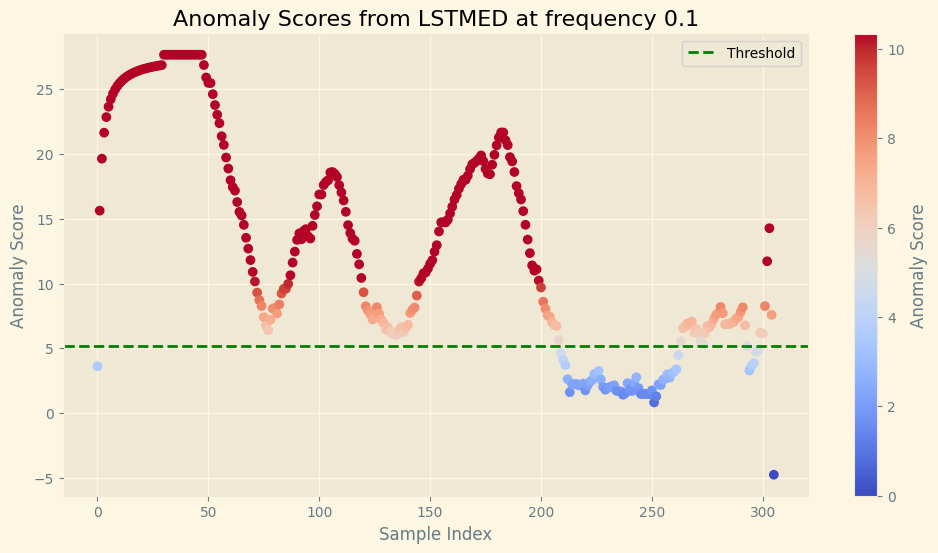

Number of anomalies detected: 244


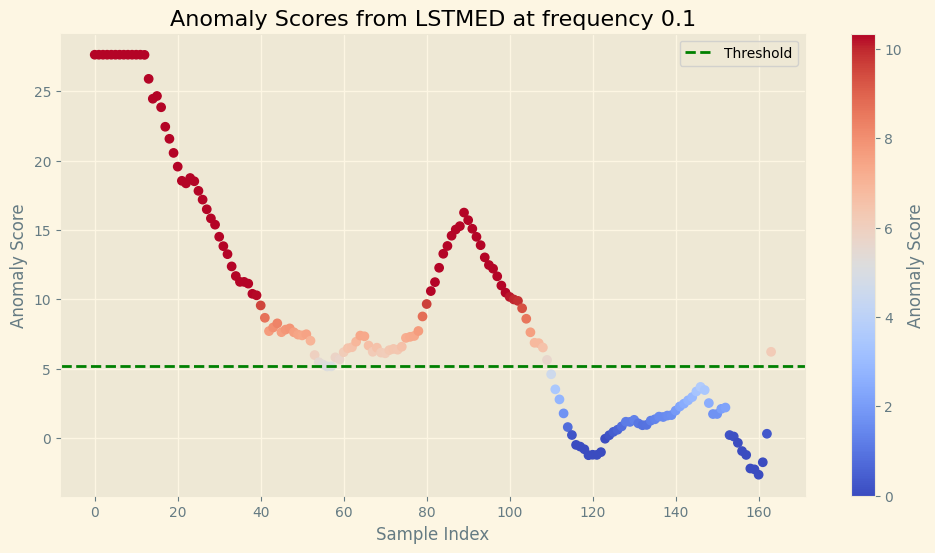

Number of anomalies detected: 109


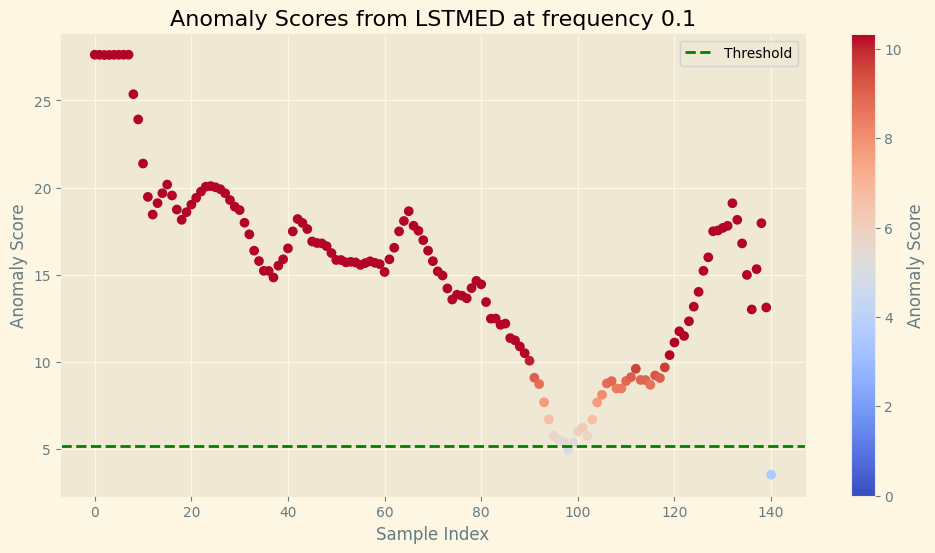

Number of anomalies detected: 139


In [20]:
anomalies_detected = plot_anomalies(anomaly_scores, freq, threshold)
anomalies_detected1 = plot_anomalies(anomaly_scores1, freq, threshold)
anomalies_detected5 = plot_anomalies(anomaly_scores5, freq, threshold)

In [21]:
X_test_start_end['anomaly_scores'] = anomaly_scores
X_test_start_end['is_collision'] = y_collisions_predict
X_test_start_end1['anomaly_scores'] = anomaly_scores1
X_test_start_end1['is_collision'] = y_collisions_predict1
X_test_start_end5['anomaly_scores'] = anomaly_scores5
X_test_start_end5['is_collision'] = y_collisions_predict5

In [22]:
def compute_metrics(anomaly_scores, y_test, threshold):
    
    print(f"Threshold: {threshold:.4f}")
    
    roc_auc = roc_auc_score(y_test, anomaly_scores)

    print(f"ROC AUC Score: {roc_auc:.4f}")
    
    # Calculate F1 score
    f1 = f1_score(y_test, anomaly_scores > threshold)
    print(f"F1 Score: {f1:.4f}")
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, anomaly_scores > threshold)
    print(f"Accuracy: {accuracy:.4f}")
    
    # Calculate precision
    precision = precision_score(y_test, anomaly_scores > threshold)
    print(f"Precision: {precision:.4f}")
    
    # Calculate recall
    recall = recall_score(y_test, anomaly_scores > threshold)
    print(f"Recall: {recall:.4f}")
    
    print(classification_report(y_test, anomaly_scores > threshold))

In [23]:
compute_metrics(anomaly_scores, y_collision, threshold)
print("############################################")
compute_metrics(anomaly_scores1, y_collision_1, threshold)
print("############################################")
compute_metrics(anomaly_scores5, y_collision_5, threshold)

Threshold: 5.1701
ROC AUC Score: 0.5152
F1 Score: 0.4814
Accuracy: 0.4085
Precision: 0.3443
Recall: 0.8000
              precision    recall  f1-score   support

           0       0.66      0.20      0.31       201
           1       0.34      0.80      0.48       105

    accuracy                           0.41       306
   macro avg       0.50      0.50      0.40       306
weighted avg       0.55      0.41      0.37       306

############################################
Threshold: 5.1701
ROC AUC Score: 0.6281
F1 Score: 0.3889
Accuracy: 0.4634
Precision: 0.2569
Recall: 0.8000
              precision    recall  f1-score   support

           0       0.87      0.37      0.52       129
           1       0.26      0.80      0.39        35

    accuracy                           0.46       164
   macro avg       0.56      0.59      0.46       164
weighted avg       0.74      0.46      0.49       164

############################################
Threshold: 5.1701
ROC AUC Score: 0.4841
F1

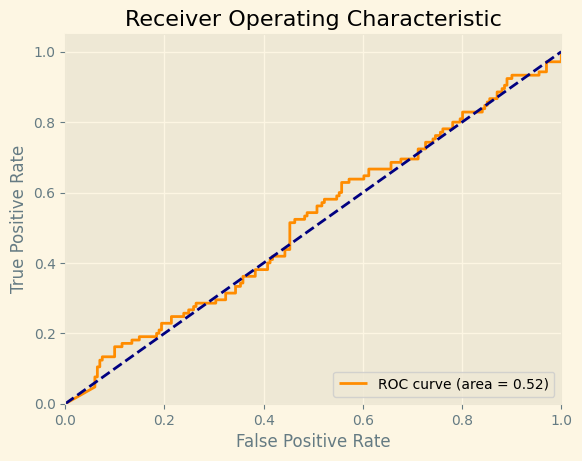

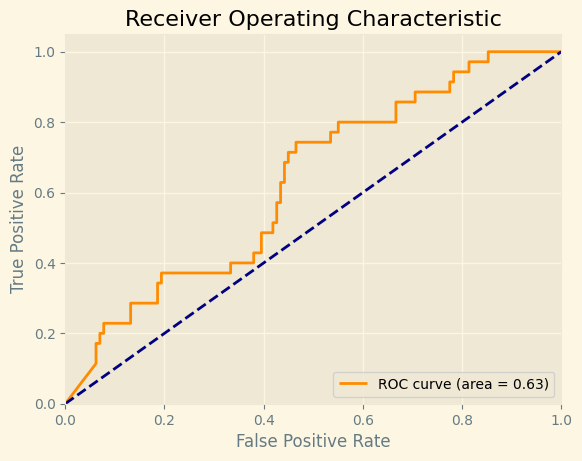

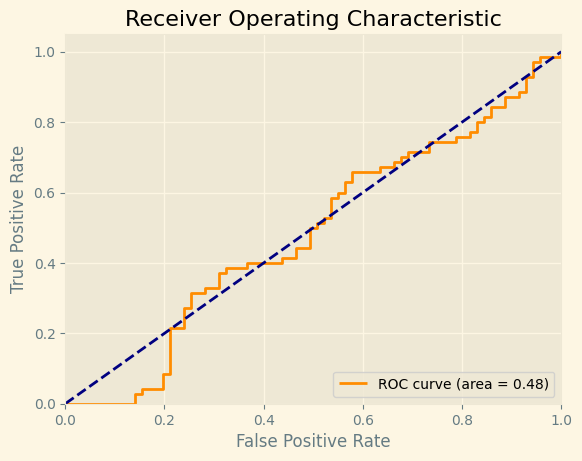

In [24]:
plot_roc_curve(y_collision, anomaly_scores)
plot_roc_curve(y_collision_1, anomaly_scores1)
plot_roc_curve(y_collision_5, anomaly_scores5)

## Map anomalies to original time series

In [25]:
def convert_to_df(collisions_zones):
    collisions_zones_df = pd.DataFrame(collisions_zones)
    # change the type of the columns to datetime
    collisions_zones_df['start'] = pd.to_datetime(collisions_zones_df['start'])
    collisions_zones_df['end'] = pd.to_datetime(collisions_zones_df['end'])
    
    return collisions_zones_df

In [26]:
collisions_zones_df = convert_to_df(collisions_zones)
collisions_zones_df_1 = convert_to_df(collisions_zones_1)
collisions_zones_df_5 = convert_to_df(collisions_zones_5)

In [27]:
plot_signals(df_collision, df_action_collision, collisions_zones_df, X_test_start_end, title="Normal data with predicted collisions", saveplot=False)

In [28]:
plot_signals(df_collision_1, df_action_collision_1, collisions_zones_df_1, X_test_start_end1, title="Collision 1 data with predicted collisions", saveplot=False)

In [29]:
plot_signals(df_collision_5, df_action_collision_5, collisions_zones_df_5, X_test_start_end5, title="Collision 5 data with predicted collisions", saveplot=False)